## Burger's equation: Two-step Method

In [1]:
# Import packages
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics.pairwise import polynomial_kernel
from tqdm import tqdm
import jax.numpy as jnp
from jax import grad, jit, jacfwd
from jaxopt import LBFGS
from jaxopt import GradientDescent
from functools import partial
from jax.config import config;
sys.path.append('/home/juanfelipe/Desktop/research/keql/source')
from parameter_learning import *
from plotlib import *
from models import * 
from kernels import *
from data_loader_Darcy import *
from loss import *
from utils import *
from jax import clear_caches

clear_caches()
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
config.update("jax_enable_x64", True)

In [2]:
# 2-step dictionary
keys = ['optim_sgm_u','optim_nugget_u','rkhs_u','optim_sgm_P','optim_nugget_P','nugget_P', 'rkhs_P_train', 'rkhs_P_train', 'f_gh_tr_pred']
two_step_dict = dict.fromkeys(keys)

### > Step 1: Learning $u's$

In [3]:
# Learn alphas and hyperparms
optim_sgm_u, alphas, optim_nugget_u = kernel_parameters_Gaussian_2D(X_tr, U_tr, N_tr)

In [4]:
# Save true values to be used in one-step 
two_step_dict['optim_sgm_u'] = optim_sgm_u 
two_step_dict['optim_nugget_u'] = optim_nugget_u 
optim_sgm_u, optim_nugget_u 

(array([1.20246384, 1.05978228, 0.64314279]), array([1.e-14, 1.e-08, 1.e-14]))

In [5]:
# Predict using interpolant and get its gradients 
U_tr_pred, U_x1_tr_pred, U_x1x1_tr_pred, U_x2_tr_pred, U_x2x2_tr_pred = predictions_Burgers_tr(X_tr, Gaussian2D, optim_sgm_u, alphas, N_tr)
U_te_pred, U_x1_te_pred, U_x1x1_te_pred, U_x2_te_pred, U_x2x2_te_pred = predictions_Burgers_te(X_te, X_tr, Gaussian2D, optim_sgm_u, alphas, N_tr, N_te)
U_gh_tr_pred, U_x1_gh_tr_pred, U_x1x1_gh_tr_pred, U_x2_gh_tr_pred, U_x2x2_gh_tr_pred = predictions_Burgers_te(X_gh_tr, X_tr, Gaussian2D, optim_sgm_u, alphas, N_tr, N_gh_tr)

In [6]:
# Save true values to warm up the onepfive method
np.save('data/U_tr_pred.npy', U_tr_pred)
np.save('data/U_te_pred.npy', U_te_pred)
np.save('data/U_gh_tr_pred.npy', U_gh_tr_pred)
# Save true gradients for comparing later  
np.save('data/U_x1_tr.npy', U_x1_tr)
np.save('data/U_x1x1_tr.npy', U_x1x1_tr) 
np.save('data/U_x2_tr.npy', U_x2_tr) 
np.save('data/U_x2x2_tr.npy', U_x2x2_tr) 

# Save gradients for one step method
# U_x1
np.save('data/U_x1_tr_pred.npy', U_x1_tr_pred)
np.save('data/U_x1_gh_tr_pred.npy', U_x1_gh_tr_pred)
np.save('data/U_x1_te_pred.npy', U_x1_te_pred)
# U_x1x1
np.save('data/U_x1x1_gh_tr_pred.npy', U_x1x1_tr_pred)
np.save('data/U_x1x1_gh_tr_pred.npy', U_x1x1_gh_tr_pred)
np.save('data/U_x1x1_te_pred.npy', U_x1x1_te_pred)
# U_x2
np.save('data/U_x2_tr_pred.npy', U_x2_tr_pred)
np.save('data/U_x2_gh_tr_pred.npy', U_x2_gh_tr_pred)
np.save('data/U_x2_te_pred.npy', U_x2_te_pred)
# U_x2x2
np.save('data/U_x2x2_tr_pred.npy', U_x2x2_tr_pred)
np.save('data/U_x2x2_gh_tr_pred.npy', U_x2x2_gh_tr_pred)
np.save('data/U_x2x2_te_pred.npy', U_x2x2_te_pred)

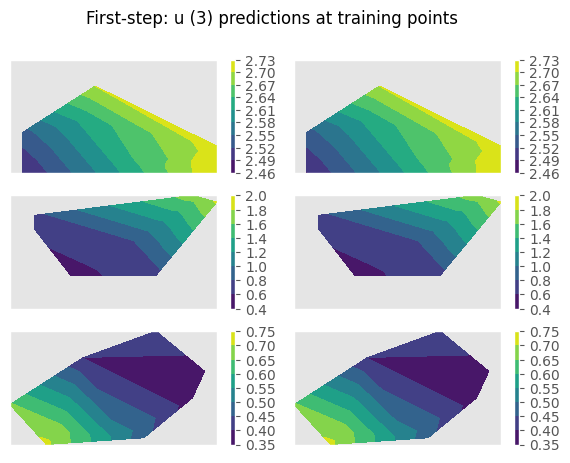

In [7]:
# Plot: u's at tr points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('First-step: u ({}) predictions at training points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_tr[i*N_tr:(i+1)*N_tr,0], X_tr[i*N_tr:(i+1)*N_tr,1], U_tr[:,i])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_tr[i*N_tr:(i+1)*N_tr,0], X_tr[i*N_tr:(i+1)*N_tr,1], U_tr_pred[:,i])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

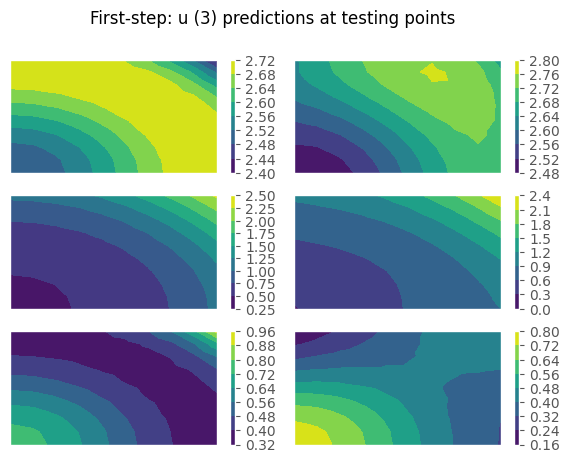

In [8]:
# Plot: u's at te points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('First-step: u ({}) predictions at testing points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], U_te[:,i])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], U_te_pred[:,i])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

In [9]:
# NMSEs: u's at tr and te points
print('Normalized MSEs between u and u_pred for {} functions'.format(m))
for i in range(m):
    n_mse_train = rel_mse(U_tr[:,i], U_tr_pred[:,i])
    n_mse_test = rel_mse(U_te[:,i], U_te_pred[:,i])
    print('m = {} nmse_train = {}'.format(i,n_mse_train))
    print('m = {} nmse_test = {}'.format(i,n_mse_test))

Normalized MSEs between u and u_pred for 3 functions
m = 0 nmse_train = 1.977327759171753e-12
m = 0 nmse_test = 0.020726697111517558
m = 1 nmse_train = 3.935725423384364e-06
m = 1 nmse_test = 0.04893856025678135
m = 2 nmse_train = 1.5094511078833186e-13
m = 2 nmse_test = 0.1501164346913738


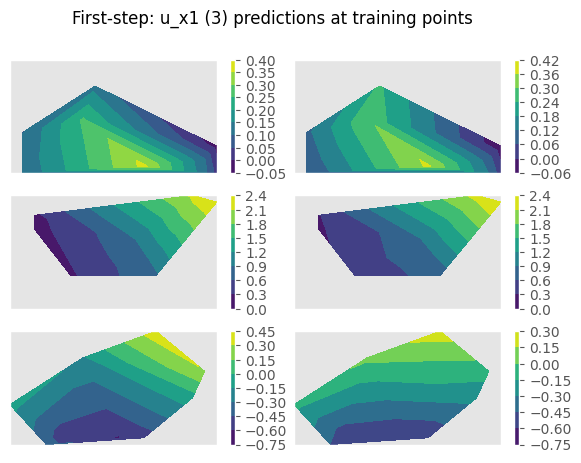

In [10]:
# Plot: u_x1's at tr points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('First-step: u_x1 ({}) predictions at training points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_tr[i*N_tr:(i+1)*N_tr,0], X_tr[i*N_tr:(i+1)*N_tr,1], U_x1_tr[:,i])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_tr[i*N_tr:(i+1)*N_tr,0], X_tr[i*N_tr:(i+1)*N_tr,1], U_x1_tr_pred[:,i])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

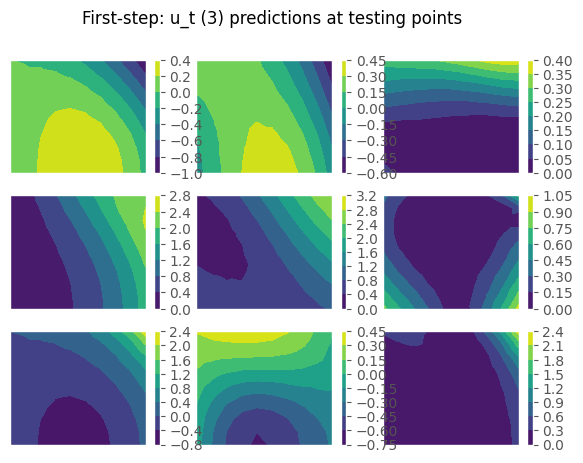

In [11]:
# Plot: u_x1's at te points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 3, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('First-step: u_t ({}) predictions at testing points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], U_x1_te[:,i])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], U_x1_te_pred[:,i])
        plt.colorbar(axsi1, ax = axs[i,1])
        axsi2 = axs[i,2].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], np.abs(U_x1_te[:,i]-U_x1_te_pred[:,i]))
        plt.colorbar(axsi2, ax = axs[i,2])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])
        axs[i,2].set_yticklabels([])
        axs[i,2].set_xticklabels([])
        axs[i,2].set_yticks([])
        axs[i,2].set_xticks([])

In [12]:
# NMSEs: u_x1's at tr and te points
print('Normalized MSEs between u_x1 and u_x1_pred for {} functions'.format(m))
for i in range(m):
    n_mse_train = rel_mse(U_x1_tr[:,i], U_x1_tr_pred[:,i])
    n_mse_test = rel_mse(U_x1_te[:,i], U_x1_te_pred[:,i])
    print('m = {} nmse_train = {}'.format(i,n_mse_train))
    print('m = {} nmse_test = {}'.format(i,n_mse_test))

Normalized MSEs between u_x1 and u_x1_pred for 3 functions
m = 0 nmse_train = 0.26764262010771817
m = 0 nmse_test = 0.5545156950651463
m = 1 nmse_train = 0.056661313528576736
m = 1 nmse_test = 0.25770449811336726
m = 2 nmse_train = 0.4269965399643464
m = 2 nmse_test = 0.8739950117457499


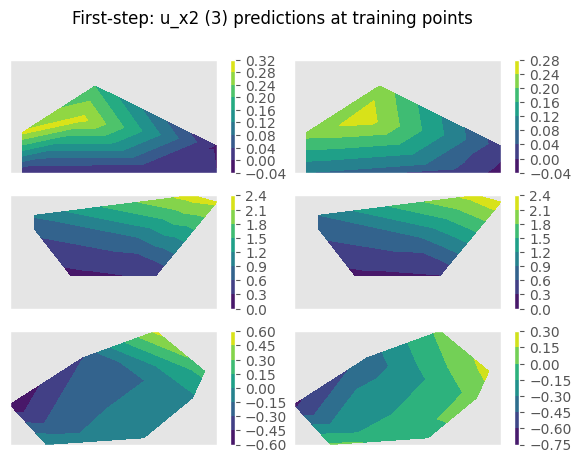

In [13]:
# Plot: u_x2's at tr points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('First-step: u_x2 ({}) predictions at training points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_tr[i*N_tr:(i+1)*N_tr,0], X_tr[i*N_tr:(i+1)*N_tr,1], U_x2_tr[:,i])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_tr[i*N_tr:(i+1)*N_tr,0], X_tr[i*N_tr:(i+1)*N_tr,1], U_x2_tr_pred[:,i])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

plt.show()

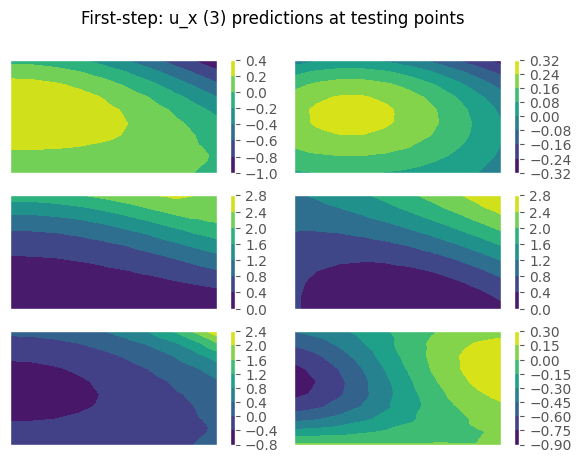

In [14]:
# Plot: u_x2's at te points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('First-step: u_x ({}) predictions at testing points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], U_x2_te[:,i])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], U_x2_te_pred[:,i])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

In [15]:
# NMSEs: u_x2's at tr and te points
print('Normalized MSEs between u_x2 and u_x2_pred for {} functions'.format(m))
for i in range(m):
    n_mse_train = rel_mse(U_x2_tr[:,i], U_x2_tr_pred[:,i])
    n_mse_test = rel_mse(U_x2_te[:,i], U_x2_te_pred[:,i])
    print('m = {} nmse_train = {}'.format(i,n_mse_train))
    print('m = {} nmse_test = {}'.format(i,n_mse_test))

Normalized MSEs between u_x2 and u_x2_pred for 3 functions
m = 0 nmse_train = 0.271460369962707
m = 0 nmse_test = 0.6965061315218241
m = 1 nmse_train = 0.042030805352053724
m = 1 nmse_test = 0.1687143576461188
m = 2 nmse_train = 0.5524524915361808
m = 2 nmse_test = 0.8321953076536935


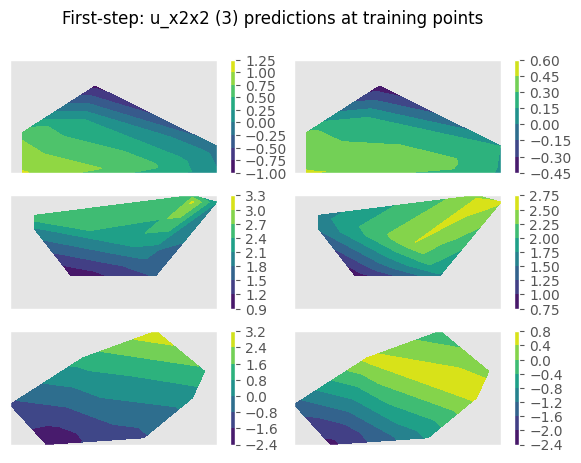

In [16]:
# Plot: u_x2x2's at tr points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('First-step: u_x2x2 ({}) predictions at training points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_tr[i*N_tr:(i+1)*N_tr,0], X_tr[i*N_tr:(i+1)*N_tr,1], U_x2x2_tr[:,i])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_tr[i*N_tr:(i+1)*N_tr,0], X_tr[i*N_tr:(i+1)*N_tr,1], U_x2x2_tr_pred[:,i])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

plt.show()

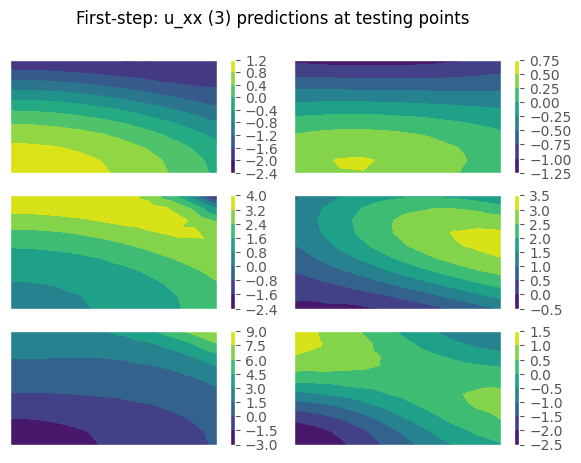

In [17]:
# Plot: u_x2x2's at te points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('First-step: u_xx ({}) predictions at testing points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], U_x2x2_te[:,i])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], U_x2x2_te_pred[:,i])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

In [18]:
# NMSEs: u_xx's at tr and te points
print('Normalized MSEs between u and u_pred for {} functions'.format(m))
for i in range(m):
    n_mse_train = rel_mse(U_x2x2_tr[:,i], U_x2x2_tr_pred[:,i])
    n_mse_test = rel_mse(U_x2x2_te[:,i], U_x2x2_te_pred[:,i])
    print('m = {} nmse_train = {}'.format(i,n_mse_train))
    print('m = {} nmse_test = {}'.format(i,n_mse_test))

Normalized MSEs between u and u_pred for 3 functions
m = 0 nmse_train = 0.5383780125253432
m = 0 nmse_test = 0.5279071726807846
m = 1 nmse_train = 0.21133094578080916
m = 1 nmse_test = 0.42027652726217773
m = 2 nmse_train = 0.7295444205337654
m = 2 nmse_test = 0.963007045566662


RKHSs norms squared $u^*$

In [19]:
# RKHS^2 norms of u*'s (since more regular than u's)
rkhs_u = []
G = K_2D(Gaussian2D, X_tr, X_tr, optim_sgm_u)
G = G[:,:,0] + 1e-7*jnp.diag(jnp.diag(G[:,:,0])) # I had to regularize here (?)
alphas = np.linalg.solve(G, U_tr_pred.flatten())
rkhs_u.append(np.dot(U_tr_pred.flatten(), alphas))
# Print the norm
print('RKHS^2 norm of u^*s: {}'.format(np.array(rkhs_u)))
# Save true values to be used in 1-step
two_step_dict['rkhs_u'] = rkhs_u

RKHS^2 norm of u^*s: [1.26810664e+08]


> Step 2: Learning $P$

In [20]:
F_tr.shape

(9, 3)

In [21]:
# Set S and f
S_tr = np.hstack((X_tr, U_tr.T.reshape(-1,1), U_x1_tr_pred.T.reshape(-1,1),U_x2_tr_pred.T.reshape(-1,1),U_x1x1_tr_pred.T.reshape(-1,1), U_x2x2_tr_pred.T.reshape(-1,1))) # (m*N_tr, 7)
S_te = np.hstack((X_te, U_te.T.reshape(-1,1), U_x1_te_pred.T.reshape(-1,1),U_x2_te_pred.T.reshape(-1,1),U_x1x1_te_pred.T.reshape(-1,1),U_x2x2_te_pred.T.reshape(-1,1))) # (m*N_te, 7)
S_gh_tr = np.hstack((X_gh_tr, U_gh_tr.T.reshape(-1,1), U_x1_gh_tr_pred.T.reshape(-1,1),U_x2_gh_tr_pred.T.reshape(-1,1),U_x1x1_gh_tr_pred.T.reshape(-1,1),U_x2x2_gh_tr_pred.T.reshape(-1,1))) # (m*N_te, 7)

f_tr = F_tr.T.flatten()
f_te = F_te.T.flatten()
f_gh_tr = F_gh_tr.T.flatten()

scaler_S_tr = MinMaxScaler()
S_tr_s = scaler_S_tr.fit_transform(S_tr)
S_te_s = scaler_S_tr.transform(S_te)
S_gh_tr_s = scaler_S_tr.transform(S_gh_tr)

f_tr2 = -2*(S_tr[:,5] + S_tr[:,6])
f_te2 = -2*(S_te[:,5] + S_te[:,6])

$$P(S_N) vs. P^*(S_N)$$

In [22]:
#optim_sgm_P, optim_nugget_P = grid_search_RBF(S_tr_s,f_tr)
optim_d_P, optim_nugget_P = 2, 1e-16
# Save true values to be used in one-step
#two_step_dict['optim_sgm_P'] = optim_sgm_P
two_step_dict['optim_sgm_P'] = optim_d_P
two_step_dict['optim_nugget_P'] = optim_nugget_P

#krr_optimal_P = KernelRidge(kernel='rbf', alpha = optim_nugget_P, gamma=1/(2*(optim_sgm_P**2))) 
krr_optimal_P = KernelRidge(kernel='poly', alpha = optim_nugget_P, degree = optim_d_P) 

krr_optimal_P.fit(S_tr_s, f_tr) 
f_tr_pred = np.ndarray.flatten(krr_optimal_P.predict(S_tr_s)) 
f_te_pred = np.ndarray.flatten(krr_optimal_P.predict(S_te_s))
f_gh_tr_pred = np.ndarray.flatten(krr_optimal_P.predict(S_gh_tr_s))

In [23]:
#print('Optimal sigma of P^*:{}  Nugget of P^*: {:.2e}'.format(optim_sgm_P,optim_nugget_P))
print('Degree for kernel of P^*:{}  Nugget of P^*: {:.2e}'.format(optim_d_P,optim_nugget_P))

Degree for kernel of P^*:2  Nugget of P^*: 1.00e-16


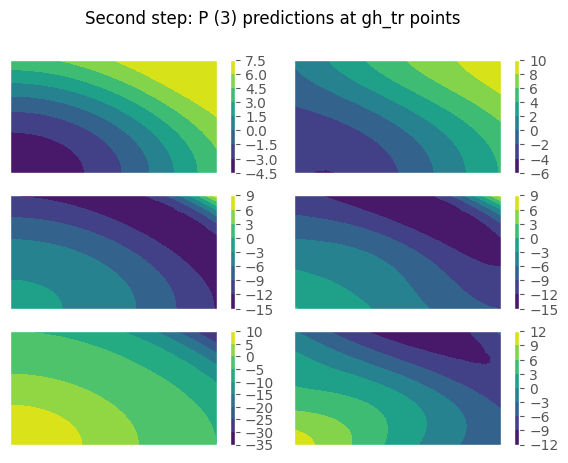

In [24]:
# Plot: P at gh_tr points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('Second step: P ({}) predictions at gh_tr points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_gh_tr[i*N_gh_tr:(i+1)*N_gh_tr,0], X_gh_tr[i*N_gh_tr:(i+1)*N_gh_tr,1], f_gh_tr[i*N_gh_tr:(i+1)*N_gh_tr])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_gh_tr[i*N_gh_tr:(i+1)*N_gh_tr,0], X_gh_tr[i*N_gh_tr:(i+1)*N_gh_tr,1], f_gh_tr_pred[i*N_gh_tr:(i+1)*N_gh_tr])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

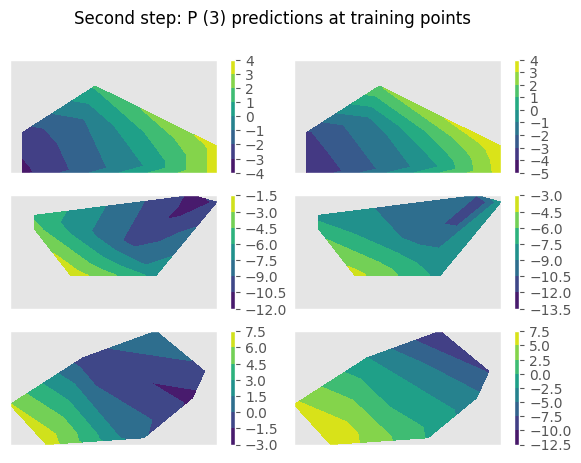

In [25]:
# Plot: P at tr points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('Second step: P ({}) predictions at training points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_tr[i*N_tr:(i+1)*N_tr,0], X_tr[i*N_tr:(i+1)*N_tr,1], f_tr2[i*N_tr:(i+1)*N_tr])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_tr[i*N_tr:(i+1)*N_tr,0], X_tr[i*N_tr:(i+1)*N_tr,1], f_tr_pred[i*N_tr:(i+1)*N_tr])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

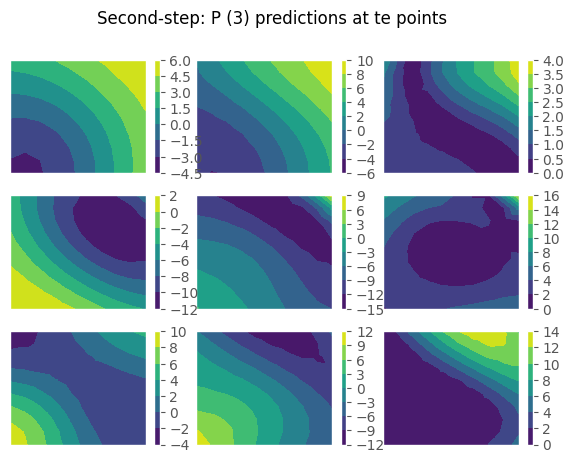

In [26]:
# Plot: P at te points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 3, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('Second-step: P ({}) predictions at te points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], f_te2[i*N_te:(i+1)*N_te])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], f_te_pred[i*N_te:(i+1)*N_te])
        plt.colorbar(axsi1, ax = axs[i,1])
        axsi2 = axs[i,2].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], np.abs(f_te2[i*N_te:(i+1)*N_te]-f_te_pred[i*N_te:(i+1)*N_te]))
        plt.colorbar(axsi2, ax = axs[i,2])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])
        axs[i,2].set_yticklabels([])
        axs[i,2].set_xticklabels([])
        axs[i,2].set_yticks([])
        axs[i,2].set_xticks([])

In [27]:
# NMSEs: P at training points and testing points
print('Normalized MSEs between P and P_pred for {} functions'.format(m))
for i in range(m):
    n_mse_train = rel_mse(f_tr2[i*N_tr:(i+1)*N_tr], f_tr_pred[i*N_tr:(i+1)*N_tr])
    n_mse_test = rel_mse(f_te2[i*N_te:(i+1)*N_te], f_te_pred[i*N_te:(i+1)*N_te])
    print('m = {} nmse_train = {}'.format(i,n_mse_train))
    print('m = {} nmse_test = {}'.format(i,n_mse_test))

Normalized MSEs between P and P_pred for 3 functions
m = 0 nmse_train = 0.19167245232350774
m = 0 nmse_test = 0.5037936977013081
m = 1 nmse_train = 0.2259237499570855
m = 1 nmse_test = 0.49363432539486596
m = 2 nmse_train = 1.245527094615649
m = 2 nmse_test = 1.7546836926024263


RKHS norm squared of $P^*$

In [28]:
# rkhs_P
nugget_P = 1e-7
G = K(Gaussian,S_tr_s,S_tr_s, optim_d_P) + nugget_P*np.eye(X_tr.shape[0]) # added nugget here !
alphas_P = np.linalg.solve(G, f_tr_pred)
rkhs_P_train = np.dot(f_tr_pred, alphas_P)
print('RKHS^s norm of P^*: {}'.format(round(rkhs_P_train,2)))
# Save true values to be used in one-step
two_step_dict['rkhs_P_train'] = rkhs_P_train
two_step_dict['nugget_P'] = nugget_P

RKHS^s norm of P^*: 33359.64


In [29]:
# rkhs_P
nugget_P = 1e-7
G_test = K(Gaussian,S_te_s,S_te_s, optim_d_P) + nugget_P*np.eye(X_te.shape[0]) # added nugget here !
alphas_P_test = np.linalg.solve(G_test, f_te_pred)
rkhs_P_test = np.dot(f_te_pred,alphas_P_test)
two_step_dict['rkhs_P_test'] = rkhs_P_test
print('RKHS^s norm of P^*: {}'.format(round(rkhs_P_test,2)))

RKHS^s norm of P^*: 73027.28


In [30]:
two_step_dict['f_gh_tr_pred'] = f_gh_tr_pred

Test

> Compute std of feature 1 $\sigma_{\text{s[:,1]}}$ of `S_tr` and perturb feature 1 of `S_tr` using $m \sigma_{\text{s[:,1]}}$ each element. $m \in (0.01,0.25)$.

In [31]:
# mses_P_all = []
# for j in tqdm(range(5)):
#     # Compute std per feature of S_tr_s
#     stds = np.std(S_tr, axis = 0)
#     beta = np.arange(0.0,0.25,0.05)
#     scales = np.outer(beta, stds) 
#     mses_P = []
#     for i in tqdm(range(len(scales))):
#         # Scales for current iteration
#         scale = scales[i,:]
#         # Copy S_tr
#         S_te = np.copy(S_tr)
#         # Perturb feature that contains u^* - Do this 10 times and average !!!
#         S_te[:,2] = np.random.normal(S_tr[:,2] , scale = scale[2])
#         # Apply step one to perturbed u's 
#         optim_sgm_u, alphas, optim_nugget_u = kernel_parameters_Gaussian_2D(X_tr, U_tr, N_tr)
#         _, _, u_x_pred, u_xx_pred = predictions_Burgers_tr(X_tr, Gaussian2D, optim_sgm_u, alphas, N_tr)
#         S_te[:,3] = u_x_pred.T.reshape(-1,1).flatten()
#         S_te[:,4] = u_xx_pred.T.reshape(-1,1).flatten()
#         # Scale the new S_te
#         S_te_s = scaler_S_tr.transform(S_te)
#         # Compute predictions on test
#         f_te_pred = krr_optimal_P.predict(S_te_s)
#         # True test -> Why if I use this rule for S_te_s the bellow rule cannot be compared with f_te_pred
#         f_true_test = -S_te[:,2]*S_te[:,3] + 0.01*S_te[:,4]
#         # Compute mse per scale 
#         mses_P.append(mean_squared_error(f_true_test,f_te_pred)/mean_squared_error(0*f_true_test,f_true_test))
# # Plot - We have a vector of dimension 4 of scales vs. mses
#     mses_P_all.append(mses_P)
# mses_P_all = np.array(mses_P_all)
# print(mses_P_all)
# mean_mses_P_all = np.mean(mses_P_all, axis = 0)
# plt.plot(beta,mean_mses_P_all,'.-')
# plt.xlabel('noise level: percentage of std of u^*')
# plt.ylabel('mse: f_pred vs. f_true')
# plt.show()

Graph above was generated by using a polynomial kernel for learning P.

In [32]:
np.save('data/two_step_dict.npy',two_step_dict)